### Logistic Population Growth

&nbsp;

The logistic population growth model captures the growth of populations over time. It is a modification of the exponential growth model. It assumes limited amount of resources may inhibit population growth as the population approaches maximum capacity of the habitat. The equation is written below.

$\frac{dN}{dt} = r_{max} \times \frac {(K-N)} {K} \times N $

where

$N$ denotes the population size

$r_{max}$ denotes the intrinsic growth rate of the population (the rate at which the population would grow in the absence of limiting factors)

$K$ denotes maximum capacity (carrying capacity) of the environment

$t$ denotes time interval (could be discrete or continuous)

&nbsp;

Refer to the link below for more details of population growth model

https://www.khanacademy.org/science/ap-biology/ecology-ap/population-ecology-ap/a/exponential-logistic-growth#:~:text=In%20logistic%20growth%2C%20a%20population's,produces%20an%20S%2Dshaped%20curve.

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd

### get data

This script uses Tasmanian devils on Maria Island as an example. The Tasmanian devil experiment on Maria Island began in 2012 and involves the relocation of healthy Tasmanian devils from mainland Tasmania to Maria Island. The goal of the program is to establish a healthy population of Tasmanian devils on Maria Island that can eventually be reintroduced to the mainland to help bolster the wild population. Maria island is effectively the perfect spot without any external mortality factors. Thus, it is the best dataset for logistic population growth.

Event Timeline

* 2012 Nov +15
* 2012 Dec -1
* 2013 Nov +13
* 2016 May -16
* 2017 Nov +8
* 2017 Jun -33
* 2018 Jun -30

Reference to Mark Recapture Estimate Data

McLennan, E.A., Belov, K., Hogg, C.J. and Grueber, C.E., 2022. How much is enough? Sampling intensity influences estimates of reproductive variance in an introduced population. Ecological Applications, 32(1), p.e02462.

https://esajournals.onlinelibrary.wiley.com/doi/abs/10.1002/eap.2462

Reference to Removal Data

Hogg, C.J., McLennan, E.A., Wise, P., Lee, A.V., Pemberton, D., Fox, S., Belov, K. and Grueber, C.E., 2020. Preserving the demographic and genetic integrity of a single source population during multiple translocations. Biological Conservation, 241, p.108318.

https://www.sciencedirect.com/science/article/abs/pii/S0006320719308110



In [2]:
target=[15, 14, 27, 99, 92, 96, 103]

### functions

In [3]:
#discrete time logistic population growth
def logistic_growth(population,t,unknown):    
    r_max,K=unknown
    N=population[0]
    dNdt=r_max*(K-N)*N/K    
    return [dNdt]

In [4]:
#form a dynamic system
#Details of estimation of dynamic system parameters can be found in the link below
# https://github.com/je-suis-tm/graph-theory/blob/master/Epidemic%20Outbreak%20project/Differential%20Equation/SARS%20differential.ipynb
def dynamicsystem(unknown):
    
    t=range(len(target))
        
    #create a list to store fitted values
    fitted=[None]*len(t)
    
    #initial value
    fitted[0]=target[0]
    
    #population zero
    N0=target[0]
    
    #there has been population manipulation throughout the process
    deduction={0:-1,2:13,5:-16,6:-27}
    
    #compute the fitted value via iterations
    for i in range(1,len(t)):
        
        interval=[t[i-1],t[i]]
        
        #wildlife addition and removal
        if t[i-1] in deduction.keys():
            N0+=deduction[t[i-1]]
            
        ans=odeint(func=logistic_growth,y0=N0,t=interval,args=(unknown,))
            
        #each iteration, the last fitted value becomes the initial value
        N0=ans[-1]
        
        #update fitted via each iteration
        fitted[i]=ans[-1][0]
                
    return fitted

In [5]:
#the cost of least square is the sum of squared error
def costfunction(unknown):    
    fitted=dynamicsystem(unknown)    
    cost=np.square(np.subtract(np.array(fitted),np.array(target))).sum()
    return cost

In [6]:
#using non linear least square to estimate the parameters of dynamic system
def estimate(r_max_guess=0.5,K_guess=500,diagnosis=False,**kwargs):
       
    #sum of squared error from initial guess
    sse=costfunction((r_max_guess,K_guess))
    
    if diagnosis:
        print(f'Initial SSE: {round(sse,2)}')
    
    lse=minimize(costfunction,x0=(r_max_guess,K_guess),
                 method='Nelder-Mead')
        
    if lse.success:   
        
        #sum of squared error from successful result
        r_max,K=lse.x
        sse=costfunction((r_max,K))
        
        if diagnosis:
            print(f'Result SSE: {round(sse,2)}')
        
        return r_max,K
        
    else:
        if diagnosis:
            print(lse)
        return 0,0

### run

In [7]:
r_max,K=estimate()

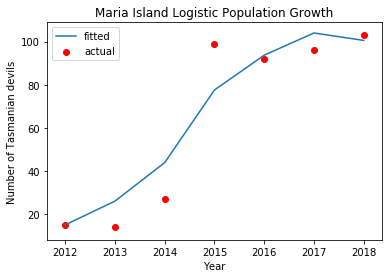

In [8]:
plt.plot(range(2012,2019),dynamicsystem((r_max,K)),label='fitted')
plt.scatter(range(2012,2019),target,c='red',label='actual')
plt.title('Maria Island Logistic Population Growth')
plt.xlabel('Year')
plt.ylabel('Number of Tasmanian devils')
plt.legend()
plt.show()